In [1]:
import json
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib
from matplotlib.cm import Set2
from tqdm.auto import tqdm

coords_path = 'data/2022-12-17 15:52:24.006277-coords.json'
data_path = 'data/2022-12-17 14:46:49.632892-output.json'
routes_path = 'data/2022-12-18 01:33:21.284286-company-routes.json'


mapbox_access_token = open("config/.mapbox_token").read()
px.set_mapbox_access_token(mapbox_access_token)

In [2]:
with open(coords_path, 'r') as fid:
    coords_data = json.load(fid)
coords = coords_data['coords']
with open(data_path, 'r') as fid:
    route_data = json.load(fid)

with open(routes_path, 'r') as fid:
    company_routes_data = json.load(fid)

In [3]:
records = []
for company, routes in company_routes_data['routes'].items():
    for route in routes:
        record = {'company': company, 'src': route[0], 'dst': route[1]}
        records.append(record)

df = pd.DataFrame(records)

available_slugs = set(coords_data['coords'].keys())
def normalize(s):
    for slug in available_slugs:
        if slug in s:
            return slug
        else:
            continue
    return None

df['src'] = df.src.map(normalize)
df['dst'] = df.dst.map(normalize)

df['src_x'] = df.src.map(lambda x: coords[x][0] if x in coords else None)
df['src_y'] = df.src.map(lambda x: coords[x][1] if x in coords else None)
df['dst_x'] = df.dst.map(lambda x: coords[x][0] if x in coords else None)
df['dst_y'] = df.dst.map(lambda x: coords[x][1] if x in coords else None)
df.head(5)


,company,src,dst,src_x,src_y,dst_x,dst_y
0,1001,sao-paulo-sp,rio-de-janeiro-rj,-46.633382,-23.550651,-43.209373,-22.911014
1,1001,sao-paulo-sp,cabo-frio-rj,-46.633382,-23.550651,-42.018923,-22.880437
2,1001,sao-paulo-sp,rio-de-janeiro-rj,-46.633382,-23.550651,-43.209373,-22.911014
3,1001,sao-paulo-sp,florianopolis-sc,-46.633382,-23.550651,-48.549610,-27.597300
4,1001,sao-paulo-sp,niteroi-rj,-46.633382,-23.550651,-43.114700,-22.888400


In [4]:

def slug_to_city(slug):
    splitted_slug = slug.split("-")
    uf = splitted_slug[-1].lower()
    place = " ".join(splitted_slug[0:-1])
    address = f'{place} / {uf}'
    return address

def generate_slug_df(df, slug, align_to_src=True):
    QUERY = f'(src == "{slug}" or dst == "{slug}")'
    fig_df = df.query(QUERY).copy(True)

    if align_to_src is True:
        inds = (fig_df.dst == slug)
    else:
        inds = (fig_df.dst != slug)

    orig_df = fig_df.copy(True)

    # Swap src/dst on applicable indices
    fig_df.loc[inds, 'src'] = orig_df[inds]['dst']
    fig_df.loc[inds, 'dst'] = orig_df[inds]['src']
    fig_df.loc[inds, 'src_x'] = orig_df[inds]['dst_x']
    fig_df.loc[inds, 'src_y'] = orig_df[inds]['dst_y']
    fig_df.loc[inds, 'dst_x'] = orig_df[inds]['src_x']
    fig_df.loc[inds, 'dst_y'] = orig_df[inds]['src_y']
    del orig_df
    return fig_df.assign(align_to_src=align_to_src)

distinct_slugs = set(df.src) | set(df.dst)

dfs = []
for slug in tqdm(distinct_slugs):
    dfs.append(generate_slug_df(df, slug, True))
    dfs.append(generate_slug_df(df, slug, False))

slug_df = pd.concat(dfs)#.set_index(["align_to_src", "src", "dst", "company"])


categories = set(slug_df.company)
n_colors = len(categories)
colors = px.colors.sample_colorscale("turbo", [n/(n_colors -1) for n in range(n_colors)])
colors = {category: colors[i] for i, category in enumerate(categories)}

slug_df = slug_df.assign(company_color=lambda df: df.company.map(colors))

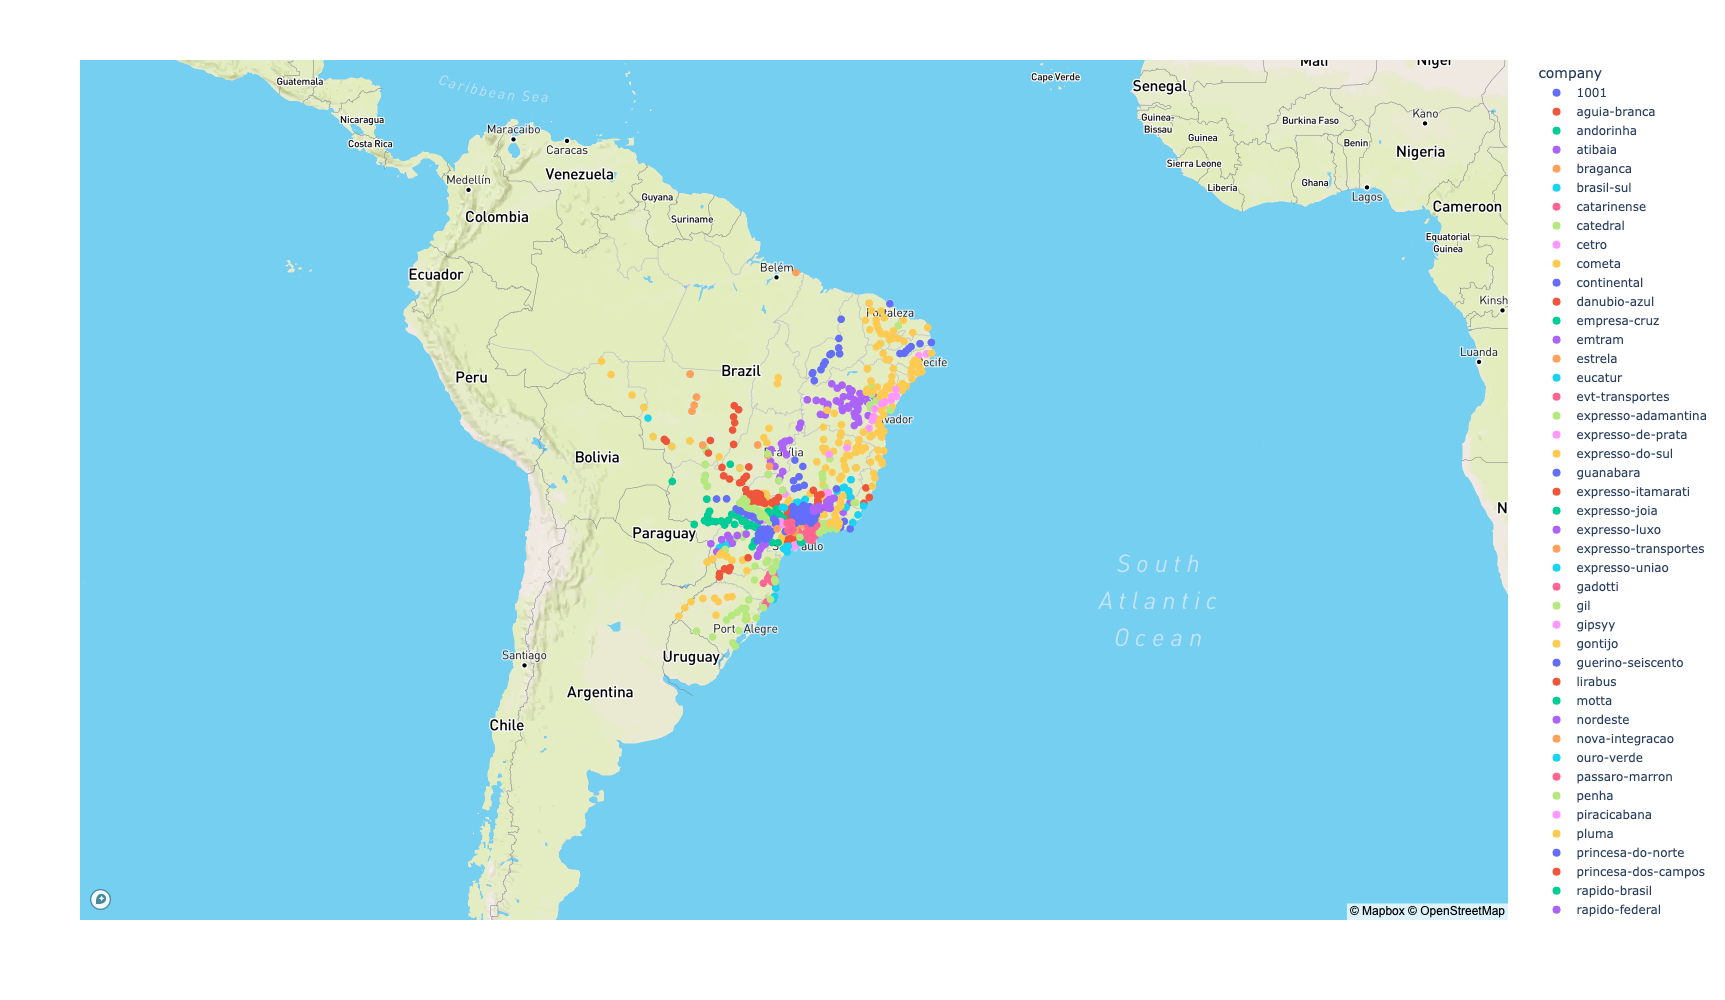

In [29]:
slug = 'sao-paulo-sp'
src_as_reference = True

def get_slug_fig_df(slug_df, slug, src_as_reference):
    if src_as_reference:
        city_query = f"src == '{slug}'"
        reference_col = 'dst'
        adjacent_col = 'src'
    else:
        city_query = f"dst == '{slug}'"
        reference_col = 'src'
        adjacent_col = 'dst'
    QUERY = f"{city_query} & align_to_src == {src_as_reference}"
    fig_df = slug_df.query(QUERY).reset_index()
    return reference_col, adjacent_col, fig_df

reference_col, adjacent_col, fig_df = get_slug_fig_df(slug_df, slug, src_as_reference)


# #inds = slug_df.company.isin(['vallesul'])
# fig_df = slug_df
#fig_df = fig_df[fig_df.dst.map(lambda x: "-ms" in x or "-go" in x or "-pr" in x or "-mt" in x if type(x) is str else False)]

fig = px.scatter_mapbox(fig_df,
                     lon=f'{reference_col}_x',
                     lat=f'{reference_col}_y', 
                     color='company',
                     hover_name=reference_col,
                     height=1000, width=1200)

fig.update_traces(marker=dict(size=8))

# fig.add_trace(go.Scattermapbox(
#     name='source',
#     lon = [fig_df[f'{adjacent_col}_x'].unique()[0]],
#     lat = [fig_df[f'{adjacent_col}_y'].unique()[0]],
#     mode = 'markers',
#     marker = dict(
#         symbol='square',
#         size = 8,
#         color = 'white'
#     )
#     )
#     )

# fig.update_geos(fitbounds="locations", projection_type='orthographic',
#     resolution=50,
#     showcoastlines=True, coastlinecolor="RebeccaPurple",
#     showocean=True, oceancolor="LightBlue",
#     showlakes=True, lakecolor="LightBlue",
#     showrivers=True, rivercolor="LightBlue",
#         showcountries=True, countrycolor="Black")
fig.update_layout(
    mapbox = {
        'accesstoken': mapbox_access_token,
        'style': "outdoors", 'zoom': 3},
    showlegend = True)

fig.show()

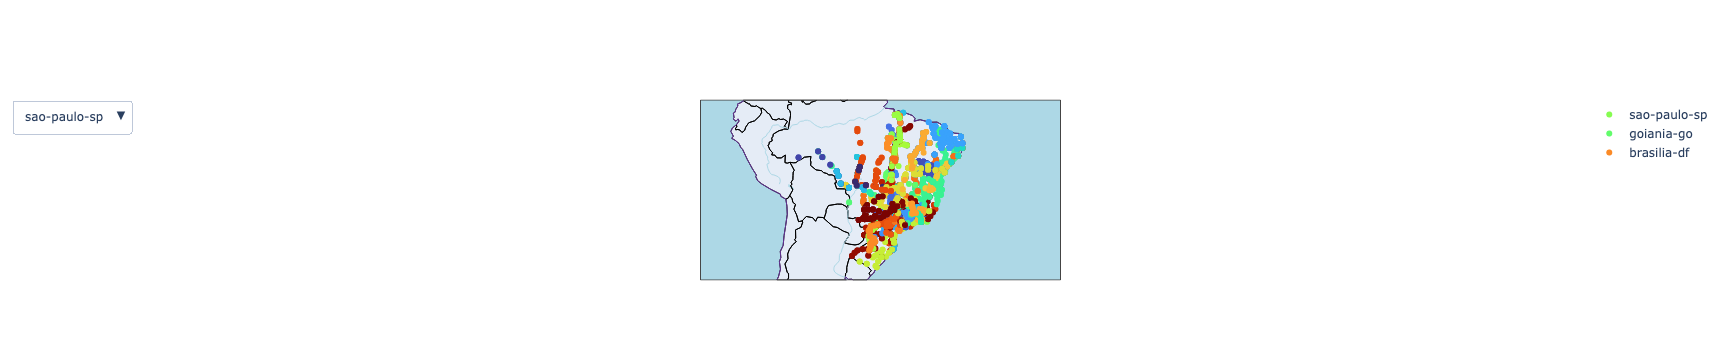

In [6]:
slugs_list = slug_df.reset_index().src.value_counts().index[0:3]

fig = go.Figure()

btn_bool_list = [False] * len(slugs_list)
buttons = []
for i, slug in enumerate(slugs_list):
    reference_col, adjacent_col, fig_df = get_slug_fig_df(slug_df, slug, True)
    fig.add_trace(go.Scattergeo(
        name=slug,
        lon=fig_df[f'{reference_col}_x'],
        lat=fig_df[f'{reference_col}_y'],
        mode='markers',
        text=fig_df[f'{reference_col}'],
        marker=dict(color=fig_df['company_color'])
    ))

    bool_list = btn_bool_list.copy()
    bool_list[i] = True
    button_args = [{'visible': bool_list}, {'title': slug}]
    button = dict(label=slug, 
                  method='update', 
                  args=button_args)
    buttons.append(button)


fig.update_layout(updatemenus=[dict(active=0,
                                     buttons=buttons)])

fig.update_geos(fitbounds="locations",
    resolution=110,
    showcoastlines=True, coastlinecolor="RebeccaPurple",
    showocean=True, oceancolor="LightBlue",
    showlakes=True, lakecolor="LightBlue",
    showrivers=True, rivercolor="LightBlue",
        showcountries=True, countrycolor="Black")
fig.show()

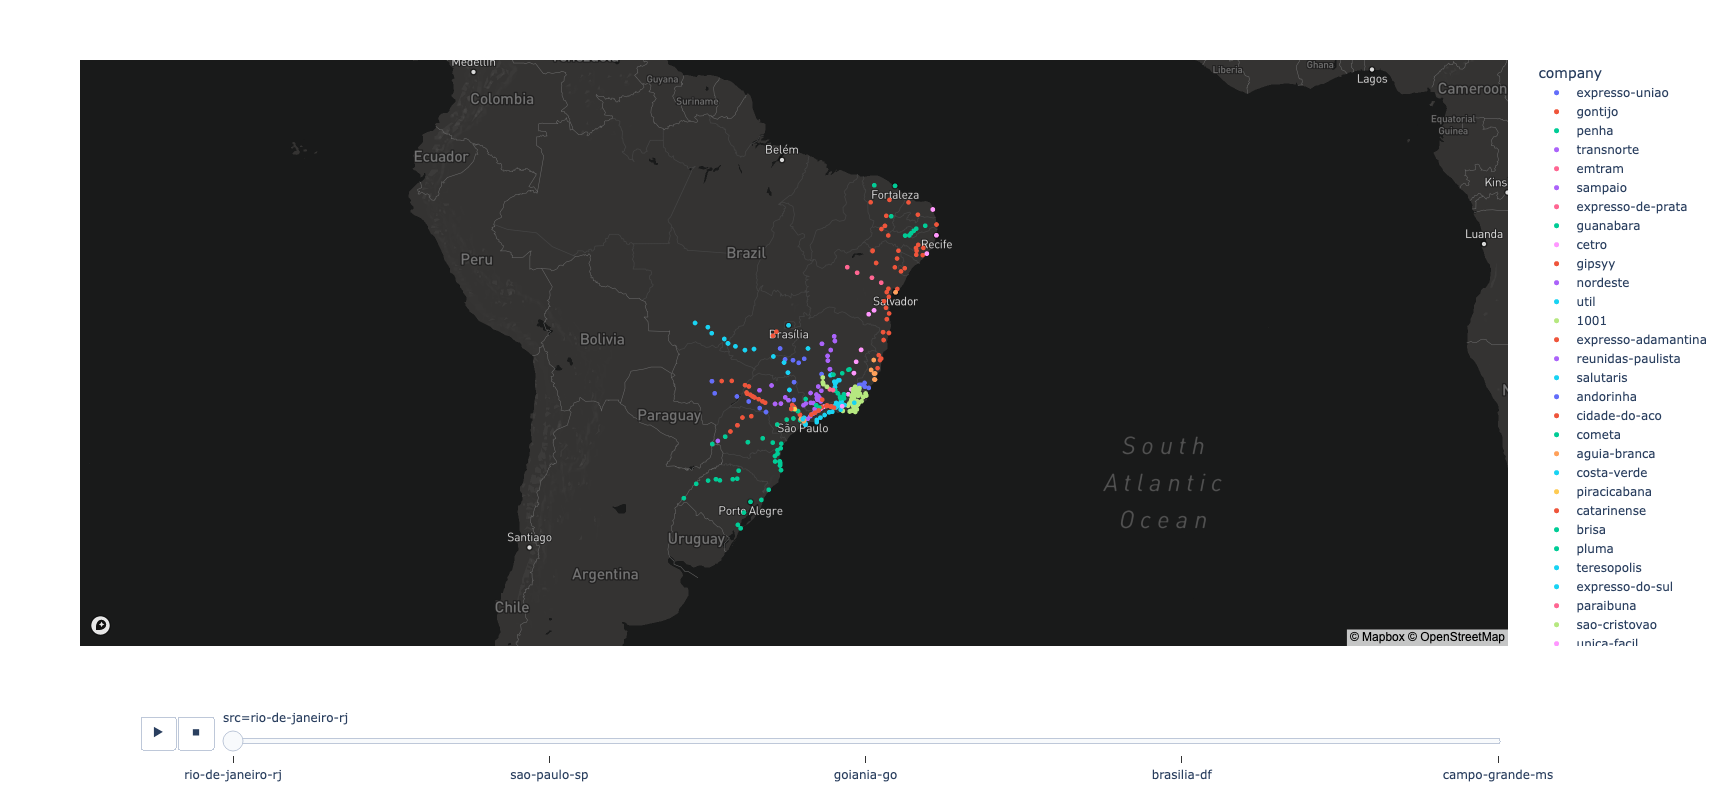

In [7]:


fig_df = slug_df.copy()

top = fig_df.src.value_counts().sort_values(ascending=False).index[0:5]

fig_df = fig_df[fig_df.src.isin(top)]

fig = px.scatter_mapbox(fig_df,
                     lon=f'dst_x',
                     lat=f'dst_y', 
                     color='company',
                     animation_frame='src',
                     #animation_group='src',
                     hover_name='dst',
                     height=800, width=1500)

fig.update_traces(marker=dict(size=5))

# fig.add_trace(go.Scattermapbox(
#     name='source',
#     lon = [fig_df[f'{adjacent_col}_x'].unique()[0]],
#     lat = [fig_df[f'{adjacent_col}_y'].unique()[0]],
#     mode = 'markers',
#     marker = dict(
#         symbol='square',
#         size = 8,
#         color = 'white'
#     )
#     )
#     )

# fig.update_geos(fitbounds="locations", projection_type='orthographic',
#     resolution=50,
#     showcoastlines=True, coastlinecolor="RebeccaPurple",
#     showocean=True, oceancolor="LightBlue",
#     showlakes=True, lakecolor="LightBlue",
#     showrivers=True, rivercolor="LightBlue",
#         showcountries=True, countrycolor="Black")
fig.update_layout(
    mapbox = {
        'accesstoken': mapbox_access_token,
        'style': "dark", 'zoom': 3},
    showlegend = True)

fig.show()

In [ ]:
slug_df.src.value_counts()